### Advanced Machine Learning

# Home Exercise #2

Assignment Due: 18/04/21 23:59

Jonathan Schler

In [1]:
student1Name="Alexander Kruglyak" # student1 name here
student1ID="323637736" # student1 ID here


student2Name="Sofya Zubtsovsky" # student2 name here
student2ID="337839112" # student2 ID here


The goal of this homework is to provide a realistic setting for a machine learning task. Therefore instructions will not specify the exact steps to carry out. Instead, it is part of theassignment to identify promising features, models and preprocessing methods and apply themas appropriate.

The overall goal is to predict whether a specific credit card transaction is fraudulent or not. Please use the data from this dataset provided on Kaggle here:https://www.kaggle.com/kartik2112/fraud-detection. The Kaggle page also contains a description of the dataset. You will use the train set for training the model and test set for validation.

You are free to manipulate the train dataset as you think is appropriate. You do not have to use the wholedataset, you can subsample if you want. While the modelling process is likely iterative, please lay out the  following tasks in the given order to facilitate grading.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import datetime

from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV

from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [3]:
COLUMNS_TO_DROP = [
#     "Unnamed: 0",
#     "trans_num",
#     "trans_date_trans_time", # TODO: we need to split it to bins of day
    
#     "first", "last", # TODO: we can think to identify nationality by name
] 

def get_continuous_features(df):
    return df.select_dtypes(exclude=['object'])

def get_categorical_features(df):
    return df.select_dtypes(include=['object'])

def read_test_data():
    return drop_columns(read_data("fraudTest.csv"), COLUMNS_TO_DROP)

def read_data(file_name):
    return pd.read_csv(file_name)

def drop_columns(df, columns):
    return df.copy().drop(columns, axis=1,errors='ignore')

In [4]:
features_description = {
'transdatetrans_time' : 'Transaction DateTime',
'cc_num' : 'Credit Card Number of Customer',
'merchant' : 'Merchant Name',
'category' : 'Category of Merchant',
'amt' : 'Amount of Transaction',
'first' : 'First Name of Credit Card Holder',
'last' : 'Last Name of Credit Card Holder',
'gender' : 'Gender of Credit Card Holder',
'street' : 'Street Address of Credit Card Holder',
'city' : 'City of Credit Card Holder',
'state' : 'State of Credit Card Holder',
'zip' : 'Zip of Credit Card Holder',
'lat' : 'Latitude Location of Credit Card Holder',
'long' : 'Longitude Location of Credit Card Holder',
'city_pop' : 'Credit Card Holder City Population',
'job' : 'Job of Credit Card Holder',
'dob' :'Date of Birth of Credit Card Holder',
'trans_num' : 'Transaction Number',
'unix_time' : 'UNIX Time of transaction',
'merch_lat' : 'Latitude Location of Merchant',
'merch_long' : 'Longitude Location of Merchant',
'is_fraud' : 'Fraud Flag'
}

title_font = {
        'color':  'darkblue',
        'weight': 'normal',
        'size': 20,
        }
labels_font = {
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

In [5]:
#### trans_date_trans_time to trans_date_category ####

def get_hour_as_category(hour):
        day_time_category = "night"
        
        if 6 <= hour and hour < 12: 
            day_time_category = "morning"
        elif hour >=12 and hour < 18:
            day_time_category = "afternoon"
        elif hour >= 18 and hour < 22:
            day_time_category = "evening"
            
        return day_time_category

def convert_to_categorical_trans_date(df):
    _df = df.copy()
    trans_date_category_list = []
    
    for  i, d in enumerate(get_categorical_features(_df).trans_date_trans_time):
        day_of_week = datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S').strftime('%A');
        hour = datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S').hour
        trans_date_category = "{}_{}".format(day_of_week, hour)
        trans_date_category_list.append(trans_date_category)
    
    _df['trans_date_category'] = trans_date_category_list
    return _df

def convert_to_categorical_trans_date_and_drop(df):
    converted_df = convert_to_categorical_trans_date(df)
    return drop_columns(converted_df, ["trans_date_trans_time"])

In [6]:
#### city_pop to city_pop_category ####

def population_as_category(p):
    category = "2M+"
    
    if p <= 100:
        category = "100-"
    elif p <= 500:
        category = "500-"
    elif p <= 1000:
        category = "1K-"
    elif p <= 2000:
        category = "2K-"
    elif p <= 3000:
        category = "3K-"
    elif p <= 5000:
        category = "5K-"
    elif p <= 10000:
        category = "10K-"
    elif p <= 30000:
        category = "30K-"
    elif p <= 50000:
        category = "50K-"
    elif p <= 100000:
        category = "100K-"
    elif p <= 200000:
        category = "200K-"
    elif p <= 500000:
        category = "500K-"
    elif p <= 1000000:
        category = "1M-"
    elif p <= 1500000:
        category = "1.5M-"
    elif p <= 2000000:
        category = "2M-"
        
    return category

def convert_to_categorical_city_pop(df):
    _df = df.copy()
    city_pop_category_list = []
    
    for p in df.city_pop:
        category = population_as_category(p)
        city_pop_category_list.append(category)
        
    _df['city_pop_category'] = city_pop_category_list
    return _df

In [7]:
def convert_cc_to_cc_type_and_drop(df):
    _df = convert_cc_to_cc_type(df)
    return drop_columns(_df, ["cc_num"])

def convert_cc_to_cc_type(df):
    _df = df.copy()
    cc_category_list = []
    
    for cc in df.cc_num:
        cc_category_list.append(get_cc_type(cc))
        
    _df['cc_type'] = cc_category_list
    return _df

def get_cc_type(cc_number):
    cc_number = str(cc_number)
    if is_american_express(cc_number): return 'AMEX'
    if is_visa(cc_number): return 'VISA'
    if is_mastercard(cc_number): return 'MasterCard'
    if is_discover(cc_number): return 'Discover'
    if is_jcb(cc_number): return 'JCB'
    if is_diners_club(cc_number): return 'DinersClub'
    if is_laser(cc_number): return 'Laser'
    if is_maestro(cc_number): return 'Maestro'
    if is_visa_electron(cc_number): return 'VisaElectron'
    if is_total_rewards_visa(cc_number): return 'TotalRewardsVisa'
    if is_diners_club_carte_blanche(cc_number): return 'DinersClubCarteBlanche'
    if is_diners_club_carte_international(cc_number): return 'DinersClubCarteInt'
    
    return 'unknown'

def is_american_express(cc_number):
    """Checks if the card is an american express. If us billing address country code, & is_amex, use vpos
    https://en.wikipedia.org/wiki/Bank_card_number#cite_note-GenCardFeatures-3
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^3[47][0-9]{13}$', cc_number))


def is_visa(cc_number):
    """Checks if the card is a visa, begins with 4 and 12 or 15 additional digits.
    :param cc_number: unicode card number
    """

    # Standard Visa is 13 or 16, debit can be 19
    if bool(re.match(r'^4', cc_number)) and len(cc_number) in [13, 16, 19]:
        return True

    return False


def is_mastercard(cc_number):
    """Checks if the card is a mastercard. Begins with 51-55 or 2221-2720 and 16 in length.
    :param cc_number: unicode card number
    """
    if len(cc_number) == 16 and cc_number.isdigit():  # Check digit, before cast to int
        return bool(re.match(r'^5[1-5]', cc_number)) or int(cc_number[:4]) in range(2221, 2721)
    return False


def is_discover(cc_number):
    """Checks if the card is discover, re would be too hard to maintain. Not a supported card.
    :param cc_number: unicode card number
    """
    if len(cc_number) == 16:
        try:
            # return bool(cc_number[:4] == '6011' or cc_number[:2] == '65' or cc_number[:6] in range(622126, 622926))
            return bool(cc_number[:4] == '6011' or cc_number[:2] == '65' or 622126 <= int(cc_number[:6]) <= 622925)
        except ValueError:
            return False
    return False


def is_jcb(cc_number):
    """Checks if the card is a jcb. Not a supported card.
    :param cc_number: unicode card number
    """
    # return bool(re.match(r'^(?:2131|1800|35\d{3})\d{11}$', cc_number))  # wikipedia
    return bool(re.match(r'^35(2[89]|[3-8][0-9])[0-9]{12}$', cc_number))  # PawelDecowski


def is_diners_club(cc_number):
    """Checks if the card is a diners club. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^3(?:0[0-6]|[68][0-9])[0-9]{11}$', cc_number))  # 0-5 = carte blance, 6 = international


def is_laser(cc_number):
    """Checks if the card is laser. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^(6304|670[69]|6771)', cc_number))


def is_maestro(cc_number):
    """Checks if the card is maestro. Not a supported card.
    :param cc_number: unicode card number
    """
    possible_lengths = [12, 13, 14, 15, 16, 17, 18, 19]
    return bool(re.match(r'^(50|5[6-9]|6[0-9])', cc_number)) and len(cc_number) in possible_lengths


# Child cards

def is_visa_electron(cc_number):
    """Child of visa. Checks if the card is a visa electron. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^(4026|417500|4508|4844|491(3|7))', cc_number)) and len(cc_number) == 16


def is_total_rewards_visa(cc_number):
    """Child of visa. Checks if the card is a Total Rewards Visa. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^41277777[0-9]{8}$', cc_number))


def is_diners_club_carte_blanche(cc_number):
    """Child card of diners. Checks if the card is a diners club carte blance. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^30[0-5][0-9]{11}$', cc_number))  # github PawelDecowski, jquery-creditcardvalidator


def is_diners_club_carte_international(cc_number):
    """Child card of diners. Checks if the card is a diners club international. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^36[0-9]{12}$', cc_number))  # jquery-creditcardvalidator

In [8]:
def get_partial_data(df, percent_of_data):
    return df.sample(frac=percent_of_data)

In [9]:
def convert_dob_to_age(df): # calculate age in days at the moment of transaction
    _df = df.copy()
    age_in_days = []
    
    for index, row in _df.iterrows():
        birth_date  = datetime.datetime.strptime(row['dob'], '%Y-%m-%d')
        trans_date  = datetime.datetime.strptime(row['trans_date_trans_time'],'%Y-%m-%d %H:%M:%S')
        age = trans_date - birth_date
        age_in_days.append(age.days)
    
    _df['age_in_days'] = age_in_days
    return _df

def convert_dob_to_age_and_drop(df):
    converted_df = convert_dob_to_age(df)
    return drop_columns(converted_df, ["dob"])

In [10]:
def convert_unix_to_hour(df):
    _df = df.copy()
    _df['trans_hour'] = _df['unix_time']  % 86400 #(86400s per 24h)
    _df['trans_hour'] /= (86400/24)
    return _df

In [11]:
def convert_unix_to_day(df):
    _df = df.copy()
    days = []
    
    for index, row in _df.iterrows():
        day = datetime.datetime.fromtimestamp(row['unix_time']).weekday()
        days.append(day)
    
    _df['trans_day'] = days
    return _df

In [12]:
def unite_state_city(df):
    _df = df.copy()
    state_city_list = []
    
    for index, row in _df.iterrows():
        state_city = row['state'] + "_" + row['city']
        state_city_list.append(state_city)
        
    _df['city'] = state_city_list
    return _df

In [13]:
def convert_and_scale(_df):
    df = _df.copy()
    
    rob_scaler = RobustScaler()

    df['scaled_amount'] = rob_scaler.fit_transform(df['amt'].values.reshape(-1,1))

    scaled_amount = df['scaled_amount']

    df.drop(['scaled_amount', 'amt'], axis=1, inplace=True)
    df.insert(0, 'scaled_amount', scaled_amount)
    
    
    converted_df = convert_cc_to_cc_type_and_drop(df)
    print("convert_cc_to_cc_type_and_drop finished")
    converted_df = convert_dob_to_age_and_drop(converted_df)
    print("convert_dob_to_age_and_drop finished")
    converted_df = unite_state_city(converted_df)
    print("unite_state_city finished")
    converted_df = convert_unix_to_hour(converted_df)
    print("convert_unix_to_hour finished")

    converted_df['category'] = converted_df['category'].astype('category').cat.codes
    converted_df['city'] = converted_df['city'].astype('category').cat.codes
    converted_df['cc_type'] = converted_df['cc_type'].astype('category').cat.codes
    converted_df['gender'] = converted_df['gender'].astype('category').cat.codes
    converted_df['merchant'] = converted_df['merchant'].astype('category').cat.codes
    converted_df['state']=converted_df['state'].astype('category').cat.codes
    converted_df['job']=converted_df['job'].astype('category').cat.codes

    return converted_df

In [14]:
from category_encoders import TargetEncoder
def target_encode_zip(data):
    orig_zip = data['zip']
    label = data['is_fraud']
    data_no_label = drop_columns(data,'is_fraud')
    te = TargetEncoder(cols='zip',return_df=True, drop_invariant = True).fit(data_no_label,label)
    transformed = te.transform(data_no_label)
    data['zip'] = transformed['zip'] # replace zip with fraud probability per zip
    return data

In [15]:
import haversine as hs

def add_feature_holder_merch_distance(df):
    _df = df.copy()
    dist_list = []
    
    for index, row in df.iterrows():
        loc1=(row['lat'],row['long'])
        loc2=(row['merch_lat'],row['merch_long'])
        dist = hs.haversine(loc1,loc2,unit=hs.Unit.METERS)
        dist_list.append(round(dist,0))
    _df['holder_merch_dist'] = dist_list
    return _df

## Task 1 Identify Features
Assemble a dataset consisting of features and target (for example in a dataframe or in two arrays X and y). What features are relevant for the prediction task? What features should be excluded because they leak the target information? Show visualizations or statistics to support your selection

In [16]:
full_train_df = pd.read_csv("fraudTrain.csv")
full_test_df = pd.read_csv("fraudTest.csv")

In [17]:
print(full_train_df.info())
print('-' * 100)
print("shape: ", full_train_df.shape)
print('-' * 100)
full_train_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,6.483370e+05,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,3.743180e+05,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,3.241685e+05,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,6.483370e+05,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,9.725055e+05,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,1.296674e+06,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [18]:
full_train_df.isnull().sum().max()

0

In [19]:
fraud_col = full_train_df['is_fraud']

AMOUNT_OF_FRAUD = fraud_col.value_counts()[1]
print('No Frauds', round(fraud_col.value_counts()[0]/len(fraud_col) * 100,2), '% of the dataset')
print('Frauds', round(fraud_col.value_counts()[1]/len(fraud_col) * 100,2), '% of the dataset')
print('Total amount of fraud transactions:', AMOUNT_OF_FRAUD)

No Frauds 99.42 % of the dataset
Frauds 0.58 % of the dataset
Total amount of fraud transactions: 7506


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

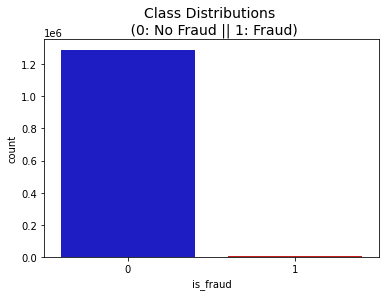

In [20]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('is_fraud', data=full_train_df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

We can see that data is very imbalances, we will create additional balanced dataset, in order to identify how features are corelated.

In [21]:
def create_balanced_data_set(original_df, amonut_of_fraud):
    _df = original_df.copy()
    _df = _df.sample(frac=1)
    fraud_df = _df.loc[_df['is_fraud'] == 1]
    non_fraud_df = _df.loc[_df['is_fraud'] == 0][:amonut_of_fraud]
    normal_distributed_df = pd.concat([fraud_df, non_fraud_df]).sample(frac=1, random_state=42)
    return normal_distributed_df

normal_distributed_train_df = create_balanced_data_set(full_train_df, AMOUNT_OF_FRAUD)

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

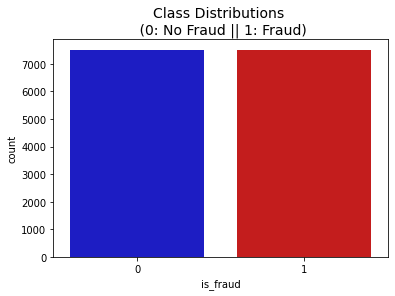

In [22]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('is_fraud', data=normal_distributed_train_df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

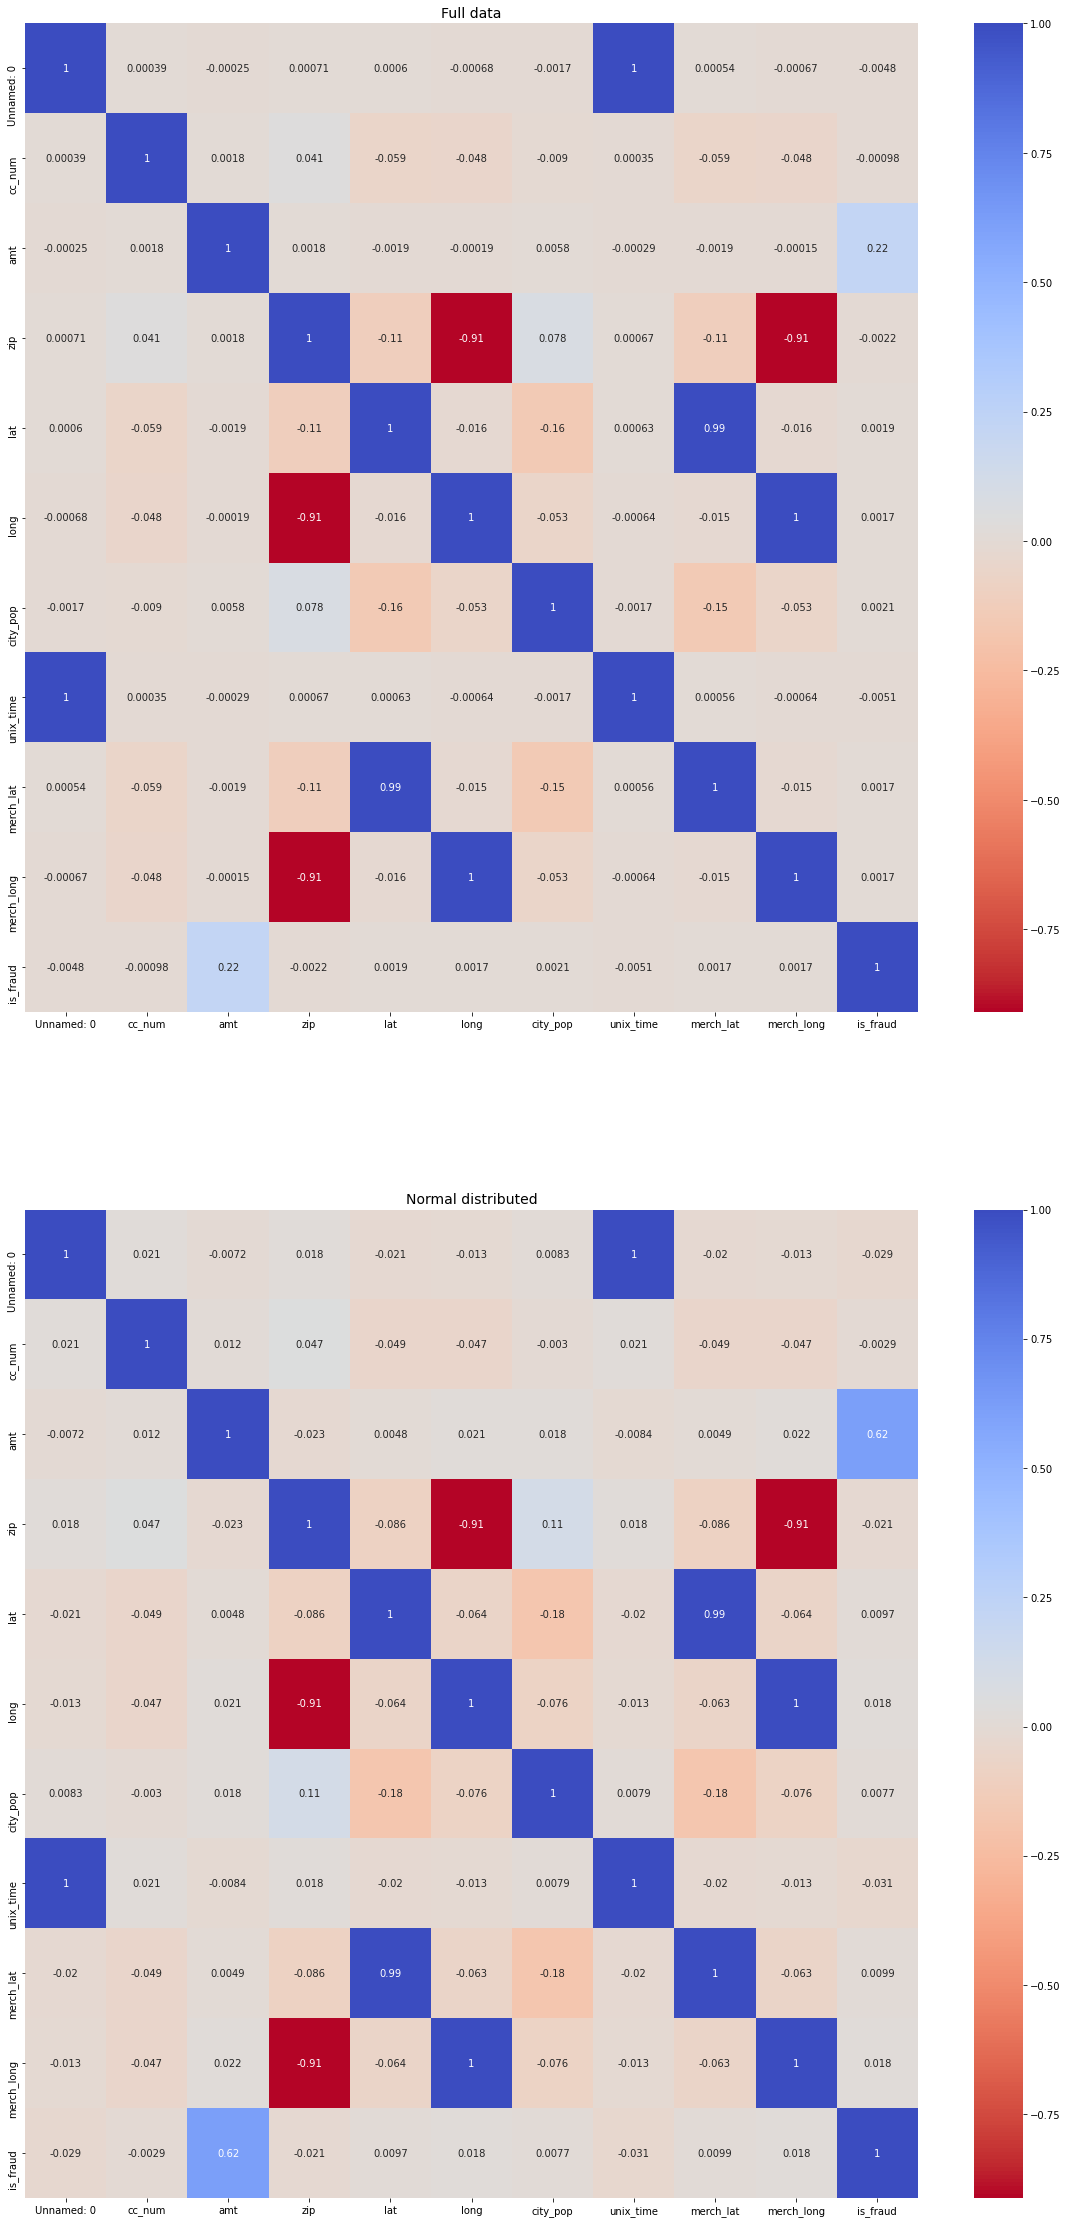

In [23]:
def show_correlation_matrices(original, norma_distributed, annot=True):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,40))

    sns.heatmap(original.corr(), cmap='coolwarm_r', annot_kws={'size':10},annot=annot, ax=ax1)
    ax1.set_title("Full data", fontsize=14)

    sns.heatmap(norma_distributed.corr(), cmap='coolwarm_r', annot_kws={'size':10},annot=annot, ax=ax2)
    ax2.set_title("Normal distributed", fontsize=14)
    plt.show()

show_correlation_matrices(full_train_df, normal_distributed_train_df)

Amount seems like strong feature for is fraud prediction, all the rest of the features, seems to be irrelevant
Let's see what we can do with categorical features

In [29]:
for (featureName, featureData) in full_train_df.select_dtypes(include=['object']).iteritems():
    print("{} has unique values: {}".format(featureName, featureData.nunique()))

trans_date_trans_time has unique values: 1274791
merchant has unique values: 693
category has unique values: 14
first has unique values: 352
last has unique values: 481
gender has unique values: 2
street has unique values: 983
city has unique values: 894
state has unique values: 51
job has unique values: 494
dob has unique values: 968
trans_num has unique values: 1296675


In [24]:
def move_is_fraud_to_fisrt_index(df):
    fraud = df['is_fraud']
    df.drop(labels=['is_fraud'], axis=1,inplace = True)
    df.insert(0, 'is_fraud', fraud)
    return df

In [25]:
columns=['state', 'gender', 'category']
dummied_full_train_df = move_is_fraud_to_fisrt_index(pd.get_dummies(full_train_df, columns=columns))
dummied_normal_distributed_train_df = move_is_fraud_to_fisrt_index(pd.get_dummies(normal_distributed_train_df, columns=columns))

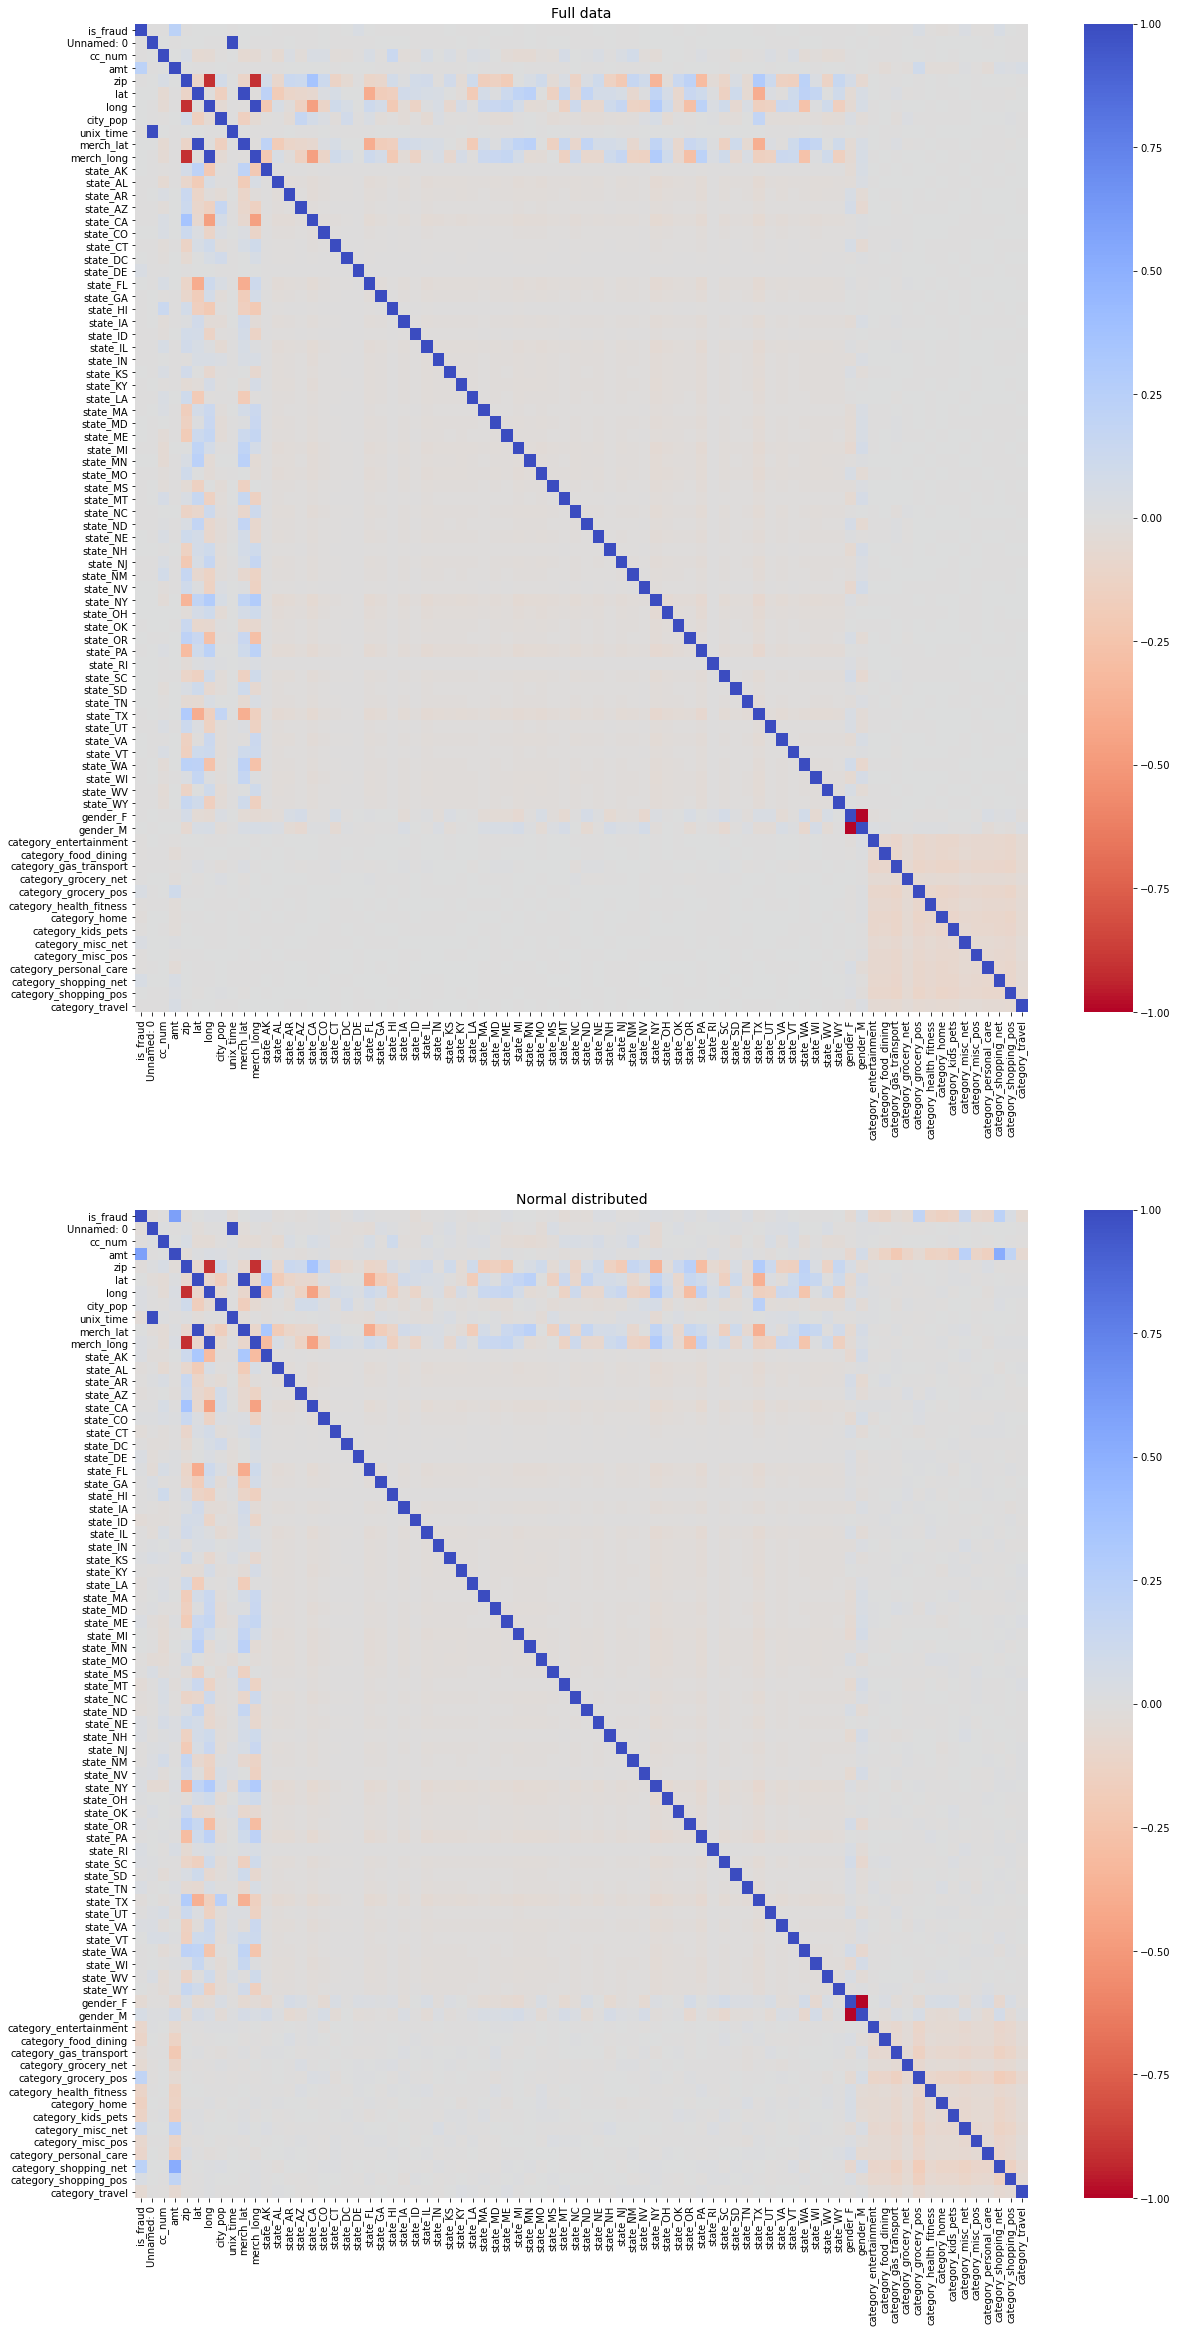

In [32]:
show_correlation_matrices(dummied_full_train_df, dummied_normal_distributed_train_df, False)

We can see that gender and state (as well as street and zip code) are not strong features,
But category has good correlation with fraud.

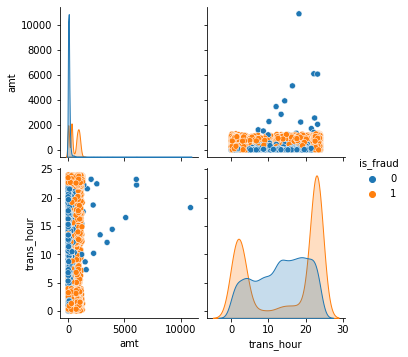

In [33]:
time_converted_train_df = convert_unix_to_hour(full_train_df)
time_converted_normal_distributed_train_df = convert_unix_to_hour(normal_distributed_train_df)
sns.pairplot(time_converted_normal_distributed_train_df[['amt','trans_hour', 'is_fraud']], hue='is_fraud')

Short conclusion about features to this point:

<del>Unnamed: 0</del> - just index, not relevant

<del>trans_date_trans_time</del> - we will use unix_time instead
    
<del>first</del> - seems like not relevant feature

<del>last</del> - seems like not relevant feature

<del>gender</del> - according to dummies values gender not related to fraudules actvivity

<del>street</del> - according to state and zip code we conclude that street not related

<del>lat, long </del>

<del>cc_num</del> - unique values, not relevant right now

<del>merch_lat, merch_long<del>

<del>merchant</del> - we will use category
    
state

zip




category

amt

city  

city_pop

job     

dob     

trans_num 

unix_time 

 



In [26]:
### T E S T data

columns_to_drop = ['Unnamed: 0', "trans_date_trans_time", "merchant", "first", "last", "street", "city", "lat", "long", "job", "dob", "trans_num", "merch_lat", "merch_long"]

X_train_full = dummied_full_train_df.copy()
X_train_full = drop_columns(X_train_full, columns_to_drop)
Y_train_full = X_train_full['is_fraud']
del X_train_full['is_fraud']

X_train_normal_distributed = dummied_normal_distributed_train_df.copy()
X_train_normal_distributed = drop_columns(X_train_normal_distributed, columns_to_drop)
Y_train_normal_distributed = X_train_normal_distributed['is_fraud']
del X_train_normal_distributed['is_fraud']

In [36]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, PassiveAggressiveClassifier, Perceptron, RidgeClassifier, RidgeClassifierCV, SGDClassifier
from sklearn.model_selection import cross_validate

def add_score(scores_df, scores, regressorName, dataType):
    scores_df.loc[regressorName + '_' + dataType, 'f1'] = scores['test_f1'].mean()
    scores_df.loc[regressorName + '_' + dataType, 'roc_auc'] = scores['test_roc_auc'].mean()
    scores_df.loc[regressorName + '_' + dataType, 'average_precision'] = scores['test_average_precision'].mean()

scores_df = pd.DataFrame(dtype=float)    
regressors = [
    LogisticRegression,
    LogisticRegressionCV,
    PassiveAggressiveClassifier,
    Perceptron,
    RidgeClassifier,
    RidgeClassifierCV,
    SGDClassifier
]
for regressor in regressors:
    name = regressor.__name__
    print('*********' + name + '*********')
    normal_distributed_scores = cross_validate(
        regressor(),
        X_train_normal_distributed, 
        Y_train_normal_distributed, 
        cv=10,
        scoring=('roc_auc', 'average_precision', 'f1'),
        n_jobs = -1
    )

    full_scores = cross_validate(
        regressor(),
        X_train_full, 
        Y_train_full, 
        cv=10,
        scoring=('roc_auc', 'average_precision', 'f1'),
        n_jobs = -1
    )
    add_score(scores_df, full_scores, regressor.__name__, "_full_data")
    add_score(scores_df, normal_distributed_scores, regressor.__name__, "_normal_distributed")

scores_df

*********LogisticRegression*********
*********LogisticRegressionCV*********
*********PassiveAggressiveClassifier*********
*********Perceptron*********
*********RidgeClassifier*********
*********RidgeClassifierCV*********
*********SGDClassifier*********


,f1,roc_auc,average_precision
LogisticRegression__full_data,0.000000,0.500000,0.005789
LogisticRegression__normal_distributed,0.000000,0.497505,0.507387
LogisticRegressionCV__full_data,0.000000,0.500000,0.005789
LogisticRegressionCV__normal_distributed,0.000000,0.497506,0.507337
PassiveAggressiveClassifier__full_data,0.000000,0.498779,0.011392
PassiveAggressiveClassifier__normal_distributed,0.463956,0.495728,0.501009
Perceptron__full_data,0.000000,0.498365,0.006287
Perceptron__normal_distributed,0.333304,0.499362,0.504459
RidgeClassifier__full_data,0.000000,0.815307,0.190280
RidgeClassifier__normal_distributed,0.789764,0.895280,0.904978


## ADDING NEW FEATURES

In [ ]:
dummied_full_train_df.info()

In [35]:
## ADD NEW FEARUTE: distance between card holder & merchant
dummied_nf_full_train_df = add_feature_holder_merch_distance(dummied_full_train_df)

In [36]:
## ADD NEW FEARUTE: card_type
dummied_nf_full_train_df = convert_cc_to_cc_type_and_drop(dummied_nf_full_train_df)

In [37]:
dummied_nf_full_train_df = pd.get_dummies(dummied_nf_full_train_df,columns=['cc_type'])

In [38]:
## ADD NEW FEARUTE: age in days
dummied_nf_full_train_df = convert_dob_to_age_and_drop(dummied_nf_full_train_df)

In [43]:
## ADD NEW FEATURE: probability of fraud per zip
dummied_nf_full_train_df = target_encode_zip(dummied_nf_full_train_df)

In [ ]:
## ADD NEW FEATURE: state_city
#dummied_nf_full_train_df = unite_state_city(dummied_nf_full_train_df)

In [ ]:
# encode state_city to numbers
#dummied_nf_full_train_df['state_city'] = dummied_nf_full_train_df['state_city'].astype('category').cat.codes

In [44]:
## ADD NEW FEATURE: day of trans (0-6)
dummied_nf_full_train_df = convert_unix_to_day(dummied_nf_full_train_df)

In [45]:
## ADD NEW FEATURE: hour of trans (0-24)
dummied_nf_full_train_df = convert_unix_to_hour(dummied_nf_full_train_df)

In [ ]:
dummied_nf_full_train_df.info()

In [50]:
normal_nf_distributed_train_df = create_balanced_data_set(dummied_nf_full_train_df, AMOUNT_OF_FRAUD)

In [51]:
normal_nf_distributed_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15012 entries, 1194414 to 287005
Data columns (total 98 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   is_fraud                 15012 non-null  int64  
 1   Unnamed: 0               15012 non-null  int64  
 2   trans_date_trans_time    15012 non-null  object 
 3   merchant                 15012 non-null  object 
 4   amt                      15012 non-null  float64
 5   first                    15012 non-null  object 
 6   last                     15012 non-null  object 
 7   street                   15012 non-null  object 
 8   city                     15012 non-null  object 
 9   zip                      15012 non-null  float64
 10  lat                      15012 non-null  float64
 11  long                     15012 non-null  float64
 12  city_pop                 15012 non-null  int64  
 13  job                      15012 non-null  object 
 14  trans_num      

In [52]:
### T R A I N data

columns_to_drop = ['Unnamed: 0', "trans_date_trans_time", "merchant", "first", "last", "street", "city", "lat", "long", "job", "dob", "trans_num", "merch_lat", "merch_long"]

X_train_full = dummied_nf_full_train_df.copy()
X_train_full = drop_columns(X_train_full, columns_to_drop)
Y_train_full = X_train_full['is_fraud']
del X_train_full['is_fraud']

X_train_normal_distributed = normal_nf_distributed_train_df.copy()
X_train_normal_distributed = drop_columns(normal_nf_distributed_train_df, columns_to_drop)
Y_train_normal_distributed = X_train_normal_distributed['is_fraud']
del X_train_normal_distributed['is_fraud']

In [55]:
X_train_full.info()
X_train_normal_distributed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 84 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   amt                      1296675 non-null  float64
 1   zip                      1296675 non-null  float64
 2   city_pop                 1296675 non-null  int64  
 3   unix_time                1296675 non-null  int64  
 4   state_AK                 1296675 non-null  uint8  
 5   state_AL                 1296675 non-null  uint8  
 6   state_AR                 1296675 non-null  uint8  
 7   state_AZ                 1296675 non-null  uint8  
 8   state_CA                 1296675 non-null  uint8  
 9   state_CO                 1296675 non-null  uint8  
 10  state_CT                 1296675 non-null  uint8  
 11  state_DC                 1296675 non-null  uint8  
 12  state_DE                 1296675 non-null  uint8  
 13  state_FL                 1296675 non-null 

In [28]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, PassiveAggressiveClassifier, Perceptron, RidgeClassifier, RidgeClassifierCV, SGDClassifier
from sklearn.model_selection import cross_validate

In [30]:
def add_score(scores_df, scores, regressorName, dataType):
    scores_df.loc[regressorName + '_' + dataType, 'f1'] = scores['test_f1'].mean()
    scores_df.loc[regressorName + '_' + dataType, 'roc_auc'] = scores['test_roc_auc'].mean()
    scores_df.loc[regressorName + '_' + dataType, 'average_precision'] = scores['test_average_precision'].mean()

In [59]:
scores_df = pd.DataFrame(dtype=float)    
regressors = [
    LogisticRegression,
    LogisticRegressionCV,
    PassiveAggressiveClassifier,
    Perceptron,
    RidgeClassifier,
    RidgeClassifierCV,
    SGDClassifier
]
for regressor in regressors:
    name = regressor.__name__
    print('*********' + name + '*********')
    normal_distributed_scores = cross_validate(
        regressor(),
        X_train_normal_distributed, 
        Y_train_normal_distributed, 
        cv=10,
        scoring=('roc_auc', 'average_precision', 'f1')
    )

    full_scores = cross_validate(
        regressor(),
        X_train_full, 
        Y_train_full, 
        cv=10,
        scoring=('roc_auc', 'average_precision', 'f1')
    )
    add_score(scores_df, full_scores, regressor.__name__, "_full_data")
    add_score(scores_df, normal_distributed_scores, regressor.__name__, "_normal_distributed")

scores_df

*********LogisticRegression*********
*********LogisticRegressionCV*********
*********PassiveAggressiveClassifier*********
*********Perceptron*********
*********RidgeClassifier*********
*********RidgeClassifierCV*********
*********SGDClassifier*********


,f1,roc_auc,average_precision
LogisticRegression__full_data,0.000000,0.631964,0.210353
LogisticRegression__normal_distributed,0.070832,0.516725,0.529325
LogisticRegressionCV__full_data,0.000000,0.631964,0.210353
LogisticRegressionCV__normal_distributed,0.428737,0.515945,0.520483
PassiveAggressiveClassifier__full_data,0.000000,0.630440,0.147724
PassiveAggressiveClassifier__normal_distributed,0.199970,0.504311,0.523744
Perceptron__full_data,0.000000,0.625442,0.099519
Perceptron__normal_distributed,0.200059,0.500023,0.518673
RidgeClassifier__full_data,0.170435,0.882762,0.315759
RidgeClassifier__normal_distributed,0.802885,0.913209,0.918917


## Automatic undersampling - without new features

In [37]:
columns=['state', 'gender', 'category']
dummied_full_train_df = move_is_fraud_to_fisrt_index(pd.get_dummies(full_train_df, columns=columns))
X_train_full = dummied_full_train_df.copy()
X_train_full = drop_columns(X_train_full, columns_to_drop)
Y_train_full = X_train_full['is_fraud']
del X_train_full['is_fraud']

(1296675, 72)
(15012, 72)
[7506 7506]


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

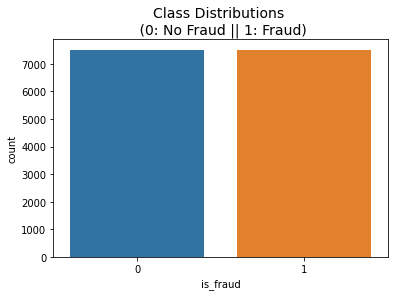

In [38]:
### check  what undersampler does
rus = RandomUnderSampler(replacement=False)
X_train_subsample, y_train_subsample = rus.fit_resample(
    X_train_full, Y_train_full)
print(X_train_full.shape)
print(X_train_subsample.shape)
print(np.bincount(y_train_subsample))
y_train_subsample.value_counts()
sns.countplot(y_train_subsample, data=X_train_subsample)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

In [ ]:
X_train_full.info()

In [39]:
rand_sample_scores_df = pd.DataFrame(dtype=float)    
regressors = [
    LogisticRegression,
    LogisticRegressionCV,
    PassiveAggressiveClassifier,
    Perceptron,
    RidgeClassifier,
    RidgeClassifierCV,
    SGDClassifier
]
for regressor in regressors:
    name = regressor.__name__
    print('*********' + name + '*********')
    undersample_pipe = make_imb_pipeline(RandomUnderSampler(), regressor())
    full_scores = cross_validate(
        undersample_pipe,
        X_train_full, 
        Y_train_full, 
        cv=10,
        scoring=('roc_auc', 'average_precision', 'f1'),
        n_jobs = -1
    )
    add_score(rand_sample_scores_df, full_scores, regressor.__name__, "rand_under")

rand_sample_scores_df

*********LogisticRegression*********
*********LogisticRegressionCV*********
*********PassiveAggressiveClassifier*********
*********Perceptron*********
*********RidgeClassifier*********
*********RidgeClassifierCV*********
*********SGDClassifier*********


,f1,roc_auc,average_precision
LogisticRegression_rand_under,0.005754,0.489298,0.006052
LogisticRegressionCV_rand_under,0.002300,0.505855,0.006531
PassiveAggressiveClassifier_rand_under,0.009713,0.483153,0.005753
Perceptron_rand_under,0.004605,0.509221,0.006420
RidgeClassifier_rand_under,0.071200,0.896856,0.202070
RidgeClassifierCV_rand_under,0.011150,0.514866,0.006633
SGDClassifier_rand_under,0.003454,0.511532,0.006550


## Automatic oversampling

In [31]:
rand_sample_scores_df = pd.DataFrame(dtype=float)    
regressors = [
    LogisticRegression,
    LogisticRegressionCV,
    PassiveAggressiveClassifier,
    Perceptron,
    RidgeClassifier,
    RidgeClassifierCV,
    SGDClassifier
]
for regressor in regressors:
    name = regressor.__name__
    print('*********' + name + '*********')
    oversample_pipe = make_imb_pipeline(RandomOverSampler(), regressor())
    full_scores = cross_validate(
        oversample_pipe,
        X_train_full, 
        Y_train_full, 
        cv=10,
        scoring=('roc_auc', 'average_precision', 'f1'),
        n_jobs = -1
    )
    add_score(rand_sample_scores_df, full_scores, regressor.__name__, "_full_data")

rand_sample_scores_df

*********LogisticRegression*********
*********LogisticRegressionCV*********
*********PassiveAggressiveClassifier*********
*********Perceptron*********
*********RidgeClassifier*********
*********RidgeClassifierCV*********
*********SGDClassifier*********


,f1,roc_auc,average_precision
LogisticRegression__full_data,0.000000,0.498421,0.006471
LogisticRegressionCV__full_data,0.001152,0.495091,0.006327
PassiveAggressiveClassifier__full_data,0.010653,0.489507,0.005962
Perceptron__full_data,0.005752,0.511975,0.006500
RidgeClassifier__full_data,0.069634,0.897378,0.209368
RidgeClassifierCV__full_data,0.010933,0.507718,0.006589
SGDClassifier__full_data,0.005755,0.487364,0.005703


## SMOTE sampling

In [32]:
for regressor in regressors:
    name = regressor.__name__
    print('*********' + name + '*********')
    smote_pipe = make_imb_pipeline(SMOTE(), regressor())
    full_scores = cross_validate(
        smote_pipe,
        X_train_full, 
        Y_train_full, 
        cv=10,
        scoring=('roc_auc', 'average_precision', 'f1'),
        n_jobs = -1
    )
    add_score(rand_sample_scores_df, full_scores, regressor.__name__, "_full_data")

rand_sample_scores_df


*********LogisticRegression*********
*********LogisticRegressionCV*********
*********PassiveAggressiveClassifier*********
*********Perceptron*********
*********RidgeClassifier*********
*********RidgeClassifierCV*********
*********SGDClassifier*********


,f1,roc_auc,average_precision
LogisticRegression__full_data,0.001152,0.495099,0.006370
LogisticRegressionCV__full_data,0.000000,0.498411,0.006463
PassiveAggressiveClassifier__full_data,0.008967,0.487391,0.009523
Perceptron__full_data,0.006904,0.509679,0.006298
RidgeClassifier__full_data,0.451452,0.836833,0.237252
RidgeClassifierCV__full_data,0.010918,0.502742,0.006342
SGDClassifier__full_data,0.005757,0.502249,0.006258


In [ ]:
f, ax1 = plt.subplots(1, 1, figsize=(24,20))

sns.heatmap(X_train.corr(), cmap='coolwarm_r', annot_kws={'size':10},annot=True, ax=ax1)
ax1.set_title("Correlation Matrix)", fontsize=14)

plt.show()

In [ ]:
print("Looking on categorical data and try to identify which can be transformed to numeric categorical")
# print("trans_date_trans_time", X_test['trans_date_trans_time'].nunique()) # too much, we need to modify it
print("merchant", X_test['merchant'].nunique())
print("category", X_test['category'].nunique())
print("gender", X_test['gender'].nunique())
print("city", X_test['city'].nunique())
print("state", X_test['state'].nunique())
print("job", X_test['job'].nunique())
print("dob", X_test['dob'].nunique())

X_train.gender = X_train.gender.astype('category').cat.codes
X_test.gender = X_test.gender.astype('category').cat.codes

X_train.job = X_train.job.astype('category').cat.codes
X_test.job = X_test.job.astype('category').cat.codes

X_train.category = X_train.category.astype('category').cat.codes
X_test.category = X_test.category.astype('category').cat.codes

X_train.merchant = X_train.merchant.astype('category').cat.codes
X_test.merchant = X_test.merchant.astype('category').cat.codes

X_train.merchant = X_train.merchant.astype('category').cat.codes
X_test.merchant = X_test.merchant.astype('category').cat.codes

X_train.dob = X_train.dob.astype('category').cat.codes
X_test.dob = X_test.dob.astype('category').cat.codes

In [ ]:
X_train = convert_cc_to_cc_type_and_drop(X_train)
X_test = convert_cc_to_cc_type_and_drop(X_test)

X_train.cc_type = X_train.cc_type.astype('category').cat.codes
X_test.cc_type = X_test.cc_type.astype('category').cat.codes

In [ ]:
X_train = unite_state_city(X_train)
X_test = unite_state_city(X_test)

X_train.city = X_train.city.astype('category').cat.codes
X_test.city = X_test.city.astype('category').cat.codes

X_train.state = X_train.state.astype('category').cat.codes
X_test.state = X_test.state.astype('category').cat.codes

In [ ]:
X_train.info()
print("-" * 100)
X_test.info()

In [ ]:

from sklearn.linear_model import LogisticRegression, 

# del X_train['is_fraud']
scores = cross_validate(LogisticRegression(),
                        X_train, Y_train, cv=10,
                        scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

In [ ]:
scores = cross_validate(RandomForestClassifier(n_estimators=100,
                                               class_weight='balanced'),
                        X_train, Y_train, cv=10,
                        scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report

# K-Nearest Neighbors is usually where the introduction class leaves off
# X_train, X_test, y_train, y_test = train_test_split(X, y)
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
nb = BernoulliNB()
nb.fit(X_train, Y_train)

print("KNN")
print(classification_report(knn.predict(X_test), y_test))
print("Naive Bayesian")
print(classification_report(nb.predict(X_test), y_test))

In [ ]:
data = drop_columns(read_data("fraudTrain.csv"), ["Unnamed: 0"])
df = data
# data = convert_cc_to_cc_type_and_drop(data)
# data = convert_dob_to_age_and_drop(data)
# data = unite_state_city(data)

In [ ]:
fraud = data[data['is_fraud']==1]
normal = data[data['is_fraud']==0]

In [ ]:
data = convert_and_scale(data)

In [ ]:
data

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = data['scaled_amount'].values
time_val = data['trans_hour'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

In [ ]:
### create balanced data set ###

df = data.sample(frac=1) #shuffled data (entire set)

fraud_df = df.loc[df['is_fraud'] == 1]
non_fraud_df = df.loc[df['is_fraud'] == 0][:AMOUNT_OF_FRAUD]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

#new_df.head()
new_df

In [ ]:
print('Distribution of the fraud in the subsample dataset')
print(new_df['is_fraud'].value_counts()/len(new_df))



sns.countplot('is_fraud', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

In [ ]:
df.shape
new_df.shape

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':10},annot=True, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r',  annot_kws={'size':10},annot=True, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

In [ ]:
columns_to_drop = ['gender','city','state','cc_type','age_in_days','merchant','amt','unix_time','trans_date_trans_time','first','last','street','trans_num','job','age','city_pop','zip','lat','long', 'merch_lat','merch_long']

In [ ]:
new_df = drop_columns(new_df,columns_to_drop)
new_df

In [ ]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForest" : RandomForestClassifier()
}

In [ ]:
new_df

In [ ]:
label = new_df['is_fraud'].values
converted_df_no_label = new_df.drop('is_fraud',axis=1).values
converted_df_no_label

In [ ]:
for key, classifier in classifiers.items():
    classifier.fit(converted_df_no_label, label)
    training_score = cross_val_score(classifier, converted_df_no_label, label, cv=5, scoring="f1")
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

In [ ]:
# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}


grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(converted_df_no_label, label)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

print("log reg: best params",grid_log_reg.best_params_)
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(converted_df_no_label, label)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_
print("grid_knears: best params",grid_knears.best_params_)

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1]} #,  'gamma': [1e-3, 1e-4]}
#               'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(converted_df_no_label, label)

# SVC best estimator
svc = grid_svc.best_estimator_
print("svc: best params",grid_svc.best_params_)

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(converted_df_no_label, label)

# tree best estimator
tree_clf = grid_tree.best_estimator_
print("tree: best params",grid_tree.best_params_)

# RandomForest
forest_params = {"criterion": ["gini", "entropy"]}   #"max_depth": [list(range(2,4,1)), 
             # "min_samples_leaf": list(range(5,7,1))}
grid_forest = GridSearchCV(RandomForestClassifier(), forest_params)
grid_forest.fit(converted_df_no_label, label)

# tree best estimator
forest_clf = grid_forest.best_estimator_
print("forest: best params",grid_forest.best_params_)


In [ ]:
### f1 score ###
log_reg_score = cross_val_score(log_reg, converted_df_no_label, label, cv=5, scoring="f1")
print('Logistic Regression Cross Validation f1 Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

knears_score = cross_val_score(knears_neighbors, converted_df_no_label, label, cv=5, scoring="f1")
print('Knears Neighbors Cross Validation f1 Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, converted_df_no_label, label, cv=5, scoring="f1")
print('Support Vector Classifier Cross Validation f1 Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, converted_df_no_label, label, cv=5, scoring="f1")
print('DecisionTree Classifier Cross Validation f1 Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

forest_score = cross_val_score(forest_clf, converted_df_no_label, label, cv=5,scoring="f1")
print('RandomForest Classifier Cross Validation f1 Score', round(forest_score.mean() * 100, 2).astype(str) + '%')



In [ ]:
test_df =  drop_columns(read_data("fraudTest.csv"), ["Unnamed: 0"])

In [ ]:
test_df.describe()
y_test = test_df['is_fraud']

In [ ]:
test_df = convert_and_scale(test_df)

In [ ]:
test_df= drop_columns(test_df,columns_to_drop)
test_df

In [ ]:
test_df = drop_columns(test_df,['is_fraud'])

forest_clf.fit(converted_df_no_label, label)
predictions = forest_clf.predict(test_df)
print(classification_report(y_test, predictions, target_names=['Normal','Is Fraud']))

In [ ]:
print(confusion_matrix(y_test, predictions))
print(f"accuracy is {model.score(test_df, y_test)}")
plot_confusion_matrix(model, test_df, y_test, cmap='gray_r',normalize='true')

In [ ]:
pd.concat([fraud.amt.describe(), normal.amt.describe()], keys=["fraud_amt", "non_fraud_amt"], axis=1)

In [ ]:
### plot all the features via seaborn ### 
percent = 0.01
columns_to_drop = ['trans_date_trans_time','state','zip','lat','long','first','last','street','trans_num','unix_time']
partial_data = get_partial_data(data,percent)
partial_data = drop_columns(partial_data,columns_to_drop)
partial_data

In [ ]:
sns.pairplot(partial_data, hue='is_fraud') 

In [ ]:
##### atm #####
plt.figure(figsize=(30, 10))

print()
plt.subplot(2, 1, 1)
subfraud = fraud #[fraud.amt<500]
subfraud.amt.hist(bins=400,weights=np.ones(len(subfraud.amt)) / len(subfraud.amt))
plt.title("Fraudulant Transaction Amount Distribution")
plt.legend()
# plt.xlim([-10,400])
# plt.ylim([0,0.1])

plt.subplot(2, 1, 2)
subnormal = normal #[normal.amt<400]
subnormal.amt.hist(bins=500, weights=np.ones(len(subnormal.amt)) / len(subnormal.amt))
plt.title("Normal Transaction Amount Distribution")
plt.legend()
# plt.xlim([-10,400])
# plt.ylim([0,0.1])

## Conclusion
We can see that transaction's amount is a good feature for fraud transaction recognition

In [ ]:
### atm via seaborn ###
plt.figure(figsize=(7,5))
sns.set_style('whitegrid')
sns.catplot(x='is_fraud',y='amt', hue='is_fraud',data=data)

In [ ]:
##### time #####

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
fraud_24time = fraud.copy()
fraud_24time.unix_time = fraud_24time.unix_time % 86400 #(86400s per 24h)
fraud_24time.unix_time /= (86400/24)
fraud_24time.unix_time.hist(bins=50,label="Fraudulant Transaction",weights=np.ones(len(fraud_24time)) / len(fraud_24time))
plt.xlim([0,24])
plt.ylim([0,0.15])
plt.xlabel("")
plt.legend()

plt.subplot(2, 1, 2)
normal_24time = normal.copy()
normal_24time.unix_time  = normal_24time.unix_time  % 86400 #(86400s per 24h)
normal_24time.unix_time  /= (86400/24)
normal_24time.unix_time .hist(bins=50,label="Non Fraudulant Transaction",weights=np.ones(len(normal_24time)) / len(normal_24time))
plt.xlim([0,24])
plt.ylim([0,0.15])
plt.legend()

## Conclusion
We can see that transaction's time is a good feature for fraud transaction recognition

In [ ]:
##### category #####
category_df = pd.concat([fraud.category.value_counts()/len(fraud.index), normal.category.value_counts()/len(normal.index)], keys=["fraud_category", "non_fraud_category"], axis=1)
fig, axes = plt.subplots(1, 1, figsize=(20,10))

category_df.plot(kind='bar',ax=axes)

## Conclusion
We can see that transaction category is a good feature for fraud recognition

In [ ]:
##### city #####
np.set_printoptions(suppress=True)
dropped = data.drop_duplicates(["city"], inplace=False)
total_pupulation = dropped.city_pop.sum()

dropped.city_pop = dropped.city_pop / total_pupulation
dropped.index  = dropped.city
dropped

city_df = pd.concat(
    [
        fraud.city.value_counts()/len(fraud.index), 
        normal.city.value_counts()/len(normal.index),
        # dropped.city_pop
    ], 
    # keys=["fraud", "normal", "normalized_pop"], 
    keys=["fraud", "normal"], 
    axis=1)

city_df

# /total_pupulation
# dropped.city_pop.value_counts()

# grouped = data.groupby('city')
# data.city.unique()
# data.loc['city', data.city.unique()]

# data.city_pop.sum()
fig, axes = plt.subplots(1, 1, figsize=(20,10))
city_df.plot(kind='bar',ax=axes)


In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(20,10))
axes.set_title("50 cities with high fraud distribution")
city_df[:50].plot(kind='bar',ax=axes)


In [ ]:
city_df.index[0]
city_count = {}
for i in range(50):
    fraud_city = fraud[fraud['city']==city_df.index[i]]
    lat_unique = fraud_city.lat.nunique()
    long_unique = fraud_city.long.nunique()
    city_count[city_df.index[i]]= lat_unique > 1  or long_unique > 1

city_count

## Conclusion
We can see that location of card holder is not a good feature to recognize fraud.

In [ ]:
fig, axes = plt.subplots(5, 4, figsize=(20, 50))

for i, ax in enumerate(axes.ravel()):
    fraud_city =  fraud[fraud['city']==city_df.index[i]]
    normal_city =  normal[normal['city']==city_df.index[i]]
    ax.scatter(normal_city.merch_lat, normal_city.merch_long, label="Normal", alpha=1,color='green')
    ax.scatter(fraud_city.merch_lat, fraud_city.merch_long,label='Fraud', alpha=1, color='red',s=400)
    ax.legend()
    feature_name = city_df.index[i]
    ax.set_title("{}".format(feature_name), fontdict=title_font)
    ax.grid()
    
plt.tight_layout()


## Conclusion
Above we plot the locations of merchant in the cities with the highest fraud density. As we can see, there is no pattern and merchan location is not a good feature to recognize the fraud. 

In [ ]:
### population ###

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
fraud.city_pop.hist(bins=50,label="Fraudulant City Population",density=True,color='red')
plt.legend()

plt.subplot(2, 1, 2)
normal.city_pop.hist(bins=50,label="Non Fraudulant City Population",density=True,color='green')
plt.legend()

## Conclusion
We can see that city population is not a good feature to distinguish between a fraud and normal transaction. 

In [ ]:
### zip code ### 
fraud.zip
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
fraud.zip.hist(bins=50,label="Fraudulant Zip",density=True)
plt.legend()

plt.subplot(2, 1, 2)
normal.zip.hist(bins=50,label="Non Fraudulant Transaction",density=True)
plt.legend()

In [ ]:
!pip install category_encoders

In [ ]:
from category_encoders import TargetEncoder
orig_zip = data['zip']
label = data['is_fraud']
data_no_label = drop_columns(data,'is_fraud')
te = TargetEncoder(cols='zip',return_df=True, drop_invariant = True).fit(data_no_label,label)
transformed = te.transform(data_no_label)
data['zip'] = transformed['zip'] # replace zip with fraud probability per zip

In [ ]:
zip_db = pd.concat([orig_zip,transformed['zip'],label], axis=1, keys=['orig_zip', 'fraud_probability','label'])
zip_faud_prob = pd.DataFrame(zip_db.groupby('orig_zip')['fraud_probability'].mean())
zip_faud_prob.sort_values(by='fraud_probability',ascending = False, inplace = True)

fig, axes = plt.subplots(1, 1, figsize=(20,10))
axes.set_title("Fraud probability per zip-code")
zip_faud_prob.plot(kind='bar',ax=axes,logy=True,rot = 45)

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(20,10))
axes.set_title("Zipcodes with the highest Fraud probability")
zip_faud_prob[:50].plot(kind='bar',ax=axes,rot = 45)

## Conclusion
We can see that there are zipcodes with high probability of fraud, therefore zipcode is a good feature to distinguish between a fraud and normal transaction. 

In [ ]:
##### state #####
state_df = pd.concat(
    [
        fraud.state.value_counts()/len(fraud.index), 
        normal.state.value_counts()/len(normal.index),
    ], 
    keys=["fraud", "normal"], 
    axis=1)


In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(20,10))
axes.set_title("Distribution of card holders per state")
state_df.plot(kind='bar',ax=axes)

In [ ]:
##### gender #####
gender_df = pd.concat(
    [
        fraud.gender.value_counts()/len(fraud.index), 
        normal.gender.value_counts()/len(normal.index),
    ], 
    keys=["fraud", "normal"], 
    axis=1)

fig, axes = plt.subplots(1, 1, figsize=(20,10))

gender_df.plot(kind='bar',ax=axes)

## Conclusion
As we can see, gender is not significally vary between fraud and normal card holders.

In [ ]:
##### job #####
job_db = pd.concat(
    [
        fraud.job.value_counts()/len(fraud.index), 
        normal.job.value_counts()/len(normal.index),
    ], 
    keys=["fraud", "normal"], 
    axis=1)

fig, axes = plt.subplots(1, 1, figsize=(20,10))

job_db.plot(kind='bar',ax=axes)

## Conclusion
We can see that job is a good feature for fraud recognition

In [ ]:
def haversine_distance(lat1, lon1, lat2, lon2):
    r = 6371
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2-lat1)
    delta_lambda = np.radians(lon2-lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
    res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)))
    return np.round(res, 2)

def calculate_holder_merch_distance(df):
    _df = df.copy()
    dist_list = []
    
    for index, row in df.iterrows():
        dist = haversine_distance(row['lat'],row['long'],row['merch_lat'],row['merch_long'])
        dist_list.append(dist)
    _df['holder_merch_dist'] = dist_list
    return _df

In [ ]:
### location ### 

fraud  = calculate_holder_merch_distance(fraud)
normal = calculate_holder_merch_distance(normal)

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
fraud.holder_merch_dist.hist(bins=50,label="Fraudulant Distance",density=True)
plt.legend()

plt.subplot(2, 1, 2)
normal.holder_merch_dist.hist(bins=50,label="Non Fraudulant Distance",density=True)
plt.legend()


## Conclusion
We can see that distance between card holder location and merchant location is not a good feature for fraud recognition

In [ ]:
##### card type #####
card_type_df = pd.concat([fraud.cc_type.value_counts()/len(fraud.index), normal.cc_type.value_counts()/len(normal.index)], keys=["fraud_category", "non_fraud_category"], axis=1)
fig, axes = plt.subplots(1, 1, figsize=(20,10))
card_type_df.plot(kind='bar',ax=axes)

In [ ]:
### avrg amount per card type ### 
fraud_avrg_card_amt = fraud.groupby('cc_type')['amt'].mean()
normal_avrg_card_amt = normal.groupby('cc_type')['amt'].mean()
amt_per_category = pd.concat([fraud_avrg_card_amt, normal_avrg_card_amt], keys=["fraud_category", "non_fraud_category"], axis=1)
fig, axes = plt.subplots(1, 1, figsize=(20,10))
amt_per_category.plot(kind='bar',ax=axes)

## Conclusion
We can see that card type is not a good feature for fraud recognition

In [ ]:
##### merchant #####
merch_type_df = pd.concat([fraud.merchant.value_counts()/len(fraud.index), normal.merchant.value_counts()//len(normal.index)], keys=["fraud_category", "non_fraud_category"], axis=1)
fig, axes = plt.subplots(1, 1, figsize=(20,10))
axes.set_title("Merchant")
merch_type_df.plot(kind='bar',ax=axes)

In [ ]:
num = 20
fig, axes = plt.subplots(1, 1, figsize=(20,10))
axes.set_title("{} {} {}".format("Top", num, "of fraud merchant"))
merch_type_df[:num].plot(kind='bar',ax=axes)

## Conclusion 
We can see that there are merchants that has only fraud transactions. 
## TBD 
What we can conclude from this? Should we take into account specific merchant when we train the model? It's heavy feature - 693 unique categories. We have to OneHot it, means +693 columns 

In [ ]:
### dob ###
plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
fraud.age_in_days.hist(bins=100,label="Fraudulant Age",density=True)
plt.legend()

plt.subplot(2, 1, 2)
normal.age_in_days.hist(bins=100,label="Non Fraudulant Age",density=True)
plt.legend()



## Conclusion
We can see that age is not a good feature for fraud recognition

In [ ]:
### average amt per category ### 
fraud_avrg_amt = fraud.groupby('category')['amt'].mean()
normal_avrg_amt = normal.groupby('category')['amt'].mean()
amt_per_category = pd.concat([fraud_avrg_amt, normal_avrg_amt], keys=["fraud_category", "non_fraud_category"], axis=1)
fig, axes = plt.subplots(1, 1, figsize=(20,10))
amt_per_category.plot(kind='bar',ax=axes)

## Conclusion
We can see that there is significant difference between average amount of transactions made in each category between fraud and normal card holder. Also we can see that the most fraud transaction are made in the Internet.

In [ ]:
plt.subplots(figsize = (14,12))
plt.title('Correlation of Numeric Features',y=1,size=16)
sns.heatmap(data.corr(),square = True,  vmax=0.8)

In [ ]:
plt.figure(figsize=(30, 10))

print()
plt.subplot(2, 1, 1)
subfraud = fraud[fraud.amt<500]
subfraud.amt.hist(bins=400,weights=np.ones(len(subfraud.amt)) / len(subfraud.amt))
plt.title("Fraudulant Transaction Amount Distribution")
plt.legend()
plt.xlim([-10,400])
plt.ylim([0,0.1])

plt.subplot(2, 1, 2)
subnormal = normal[normal.amt<400]
subnormal.amt.hist(bins=500, weights=np.ones(len(subnormal.amt)) / len(subnormal.amt))
plt.title("Normal Transaction Amount Distribution")
plt.legend()
plt.xlim([-10,400])
plt.ylim([0,0.1])

In [ ]:
df_test = read_test_data()
df_test = convert_to_categorical_trans_date_and_drop(df_test)
# get_categorical_features(df_test).columns

df_test.amt.describe()

In [ ]:
fig, axes = plt.subplots(11, 1, figsize=(20, 70))
continuous_features = get_continuous_features(df_test)

for i, ax in enumerate(axes.ravel()):
    feature_name = continuous_features.columns[i]
    feature_human_readable_name = features_description.get(feature_name, "===NONE===")
    y = continuous_features[feature_name].value_counts().sort_index()
    ax.set_title("{} / \n {}".format(feature_name, feature_human_readable_name), fontdict=title_font)
    ax.set_ylabel("Counts", fontdict=labels_font)
    ax.plot(y)
    ax.grid()
plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(20, 70))
x = df_test.is_fraud

for i, ax in enumerate(axes.ravel()):
    X_col = continuous_features.iloc[:, i]
#     ax.set_xlim(0, 1)
    ax.set_xlim(right=1)
    if X_col.nunique() > 10:
        ax.set_xlim(X_col.quantile(q=.0001), X_col.quantile(q=.9999))
        
    ax.scatter(x, X_col, alpha=.5)

    feature_name = continuous_features.columns[i]
    feature_human_readable_name = features_description.get(feature_name, "===NONE===")
    ax.set_title("{} / \n {}".format(feature_name, feature_human_readable_name), fontdict=title_font)
#     ax.set_ylabel("Price ($)", fontdict=labels_font)
    ax.grid()
    
plt.tight_layout()

In [ ]:
categorical_features = get_categorical_features(df_test)


fig, axes = plt.subplots(3, 3, figsize=(30,60))
for i, ax in enumerate(axes.ravel()):
    if(i >= len(categorical_features.columns)):
        break
    categorical_features.iloc[:,i].value_counts().plot(kind='bar',ax=ax,rot=45)
    ax.set_title(categorical_features.columns[i])

## Task 2 Preprocessing and Baseline Model

Create a simple minimum viable model by doing an initial selection of features, doing appropriate preprocessing and cross-validating a linear model. Feel free to generously exclude features or do simplified preprocessing for this task. As mentioned before, you don’t need to validate the model on the whole dataset

In [ ]:
# pay attention: train data contains 1.300.000 samples
percent = 0.2 # 20%
partial_data = get_partial_data(data,percent)
print ("data size: {}\npercent: {:.2f}\npartial_data size {}".format(len(data.index),percent,len(partial_data.index)))
partial_data

In [ ]:
colums_to_drop = ['cc_num','gender','first','last','street','trans_num','merch_lat','merch_long','dob','lat','long','city_pop','merchant','state','trans_date_trans_time','unix_time']
partial_data= drop_columns(partial_data,colums_to_drop)
partial_data

In [ ]:
categorical = partial_data.dtypes == object
ohe = ColumnTransformer([('encoder', OneHotEncoder(), categorical)], remainder='passthrough')
transformed = pd.DataFrame.sparse.from_spmatrix(ohe.fit_transform(partial_data),columns=ohe.get_feature_names()) #TBD fix names of columns to human-readable
transformed

## Task 3 Feature Engineering
Create derived features and perform more in-depth preprocessing and data cleaning. Does this improve your model? In particular, think about how to encode categorical variables.

## Task 4 Any model
Use any classification model we discussed (trees, forests, boosting, SVM) to improve your result. You can (and probably should) change your preprocessing and feature engineering to be suitable for the model. You are not required to try all of these models. Tune parameters as appropriate

## Task 5 Feature Selections
Identify features that are important for your best model. Which features are most influential,and which features could be removed without decrease in performance? Does removing irrelevant features make your model better?

## Task 6 An explainable model
Can you create an “explainable” model that is nearly as good as your best model? An explainable model should be small enough to be easily inspected - say a linear model withfew enough coefficients that you can reasonable look at all of them, or a tree with a smallnumber of leafs etc.